# Paper reproduction

In this notebook, we will have the code to perform the paper outline experiments (in order)

## Pre-experiments steps

### Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from tqdm import tqdm
import pandas as pd
import pickle
from collections import namedtuple
import networkx as nx
from copy import deepcopy

from transformer_lens import HookedTransformer
from ioi_dataset import IOIDataset, NAMES
from utils import get_omega_decomposition_all_ahs, get_components_used, get_ah_sv_set, get_heatmap_firings, get_contrib_src_dest, compute_projections, projection_intervention

NAMES = [" " + name for name in NAMES]

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('font', size=8)

torch.set_grad_enabled(False)

### Model load

In [2]:
# Loading the model with no processing (fold_ln, etc.)
model = HookedTransformer.from_pretrained("gpt2-small", device="cpu")

Loaded pretrained model gpt2-small into HookedTransformer


### Tracing data load

In [3]:
fname = f'data/results.nms-p256-f1.0-folded-expandedO-scaled.pkl'
DB = namedtuple('DB', 'contrib_sv_src contrib_sv_dest sv_signs sv_mags svs_used')
Params = namedtuple('Params', 'attn_thresh perc_contrib_thresh num_prompts')
with open(fname, 'rb') as fp:
    (db, params) = pickle.load(fp)
# Indexes: (prompt_id, layer, ah_idx, dest_token, src_token)
(contrib_sv_src, contrib_sv_dest, sv_signs, sv_mags, svs_used) = db

In [4]:
G = nx.read_graphml("data/nms-p256-f1.0-folded-expandedO-scaled.graphml")

### IOI data load

In [5]:
n_batches = 2

ioi_dataset = IOIDataset(
    prompt_type="mixed",
    N=n_batches * 128,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    seed=0,
    device=str("cpu")
)

### NSI dataset load

We are using the first 256 instances of the pile dataset, getting the first 21 tokens of each instance.

In [6]:
pile_df = pd.read_parquet("hf://datasets/NeelNanda/pile-10k/data/train-00000-of-00001-4746b8785c874cc7.parquet")
nsi_input = model.tokenizer(pile_df.text.iloc[:256].to_list(), return_tensors="pt", padding=True, truncation=True).input_ids
nsi_input = nsi_input[:, :21]

### Run the model with cache

In this step, we will do a forward pass in the model using the ```ioi_dataset``` as an input and caching all the activations.

In [7]:
# Let's cache all the prompts
logits, cache = model.run_with_cache(ioi_dataset.toks)

We also do a forward pass with the ```nsi_input```

In [8]:
logits_nsi, cache_nsi = model.run_with_cache(nsi_input)

### Computation of the Omega matrix decomposition for all AHs

In [9]:
U, S, VT, omega = get_omega_decomposition_all_ahs(model)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 144/144 [00:07<00:00, 19.05it/s]


## Reproducing the results

We use a few AHs in the paper

In [10]:
test_heads = [(8, 6), (4, 11), (3, 0), (9, 9), (9, 6), (10, 0)]

In [11]:
thresh_firing = 0.5
perc_contrib_thresh = 1.0

### Getting the SV sets and plot number of SVs used

#### IOI dataset

In [12]:
sv_sets = {}
contrib_sets = {}
# note that (0,9), (0,11), ONLY fire on src zero -- all they ever do is fire on source zero
for (layer, ah_idx) in tqdm(test_heads):
    sv_sets[(layer, ah_idx)], contrib_sets[(layer, ah_idx)], n_non_firing, n_src_zero_firing, n_non_src_zero_firing = get_ah_sv_set(ioi_dataset, model, cache, layer, ah_idx, U, S, VT, perc_contrib_thresh, thresh_firing)
    print((layer,ah_idx), n_non_firing, n_src_zero_firing, n_non_src_zero_firing)

 17%|█▋        | 1/6 [00:46<03:52, 46.44s/it]

(8, 6) 35770.0 0 517


 33%|███▎      | 2/6 [01:54<03:57, 59.29s/it]

(4, 11) 31250.0 0 3825


 50%|█████     | 3/6 [02:21<02:13, 44.47s/it]

(3, 0) 34740.0 0 242


 67%|██████▋   | 4/6 [02:48<01:15, 37.55s/it]

(9, 9) 35010.0 0 305


 83%|████████▎ | 5/6 [03:15<00:33, 33.60s/it]

(9, 6) 34860.0 0 257


100%|██████████| 6/6 [03:40<00:00, 36.76s/it]

(10, 0) 34740.0 0 110


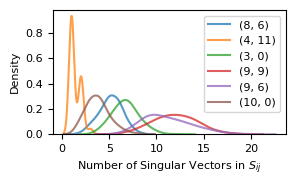

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(3,1.9), sharey=True, sharex=True)
for idx, (layer, ah_idx) in enumerate(test_heads):
    # sns.kdeplot([len(x) for x in sv_sets[(layer, ah_idx)]["src_zero_firing"]], alpha=0.5, label="Src 0 Firing", ax = ax[idx], linewidth=0.5);
    sns.kdeplot([len(x) for x in sv_sets[(layer, ah_idx)]["non_src_zero_firing"]], label = f'{(layer, ah_idx)}',
                bw_method = 0.5, alpha=0.75 ,linewidth=1.5, ax = ax);
plt.xlabel(r'Number of Singular Vectors in $S_{ij}$')
plt.legend(loc = 'best')
plt.tight_layout()
plt.savefig("figures/no-of-singular-vectors-IOI.pdf", dpi=800)

#### NSI dataset

In [14]:
sv_sets_nsi = {}
contrib_sets_nsi = {}
for (layer, ah_idx) in tqdm(test_heads):
    sv_sets_nsi[(layer, ah_idx)], contrib_sets_nsi[(layer, ah_idx)], n_non_firing, n_src_zero_firing, n_non_src_zero_firing = get_ah_sv_set(ioi_dataset, model, cache_nsi, layer, ah_idx, U, S, VT, perc_contrib_thresh, thresh_firing)
    print((layer,ah_idx), n_non_firing, n_src_zero_firing, n_non_src_zero_firing)

 17%|█▋        | 1/6 [00:26<02:11, 26.24s/it]

(8, 6) 35630.0 0 85
Layer 4, AH 11, Src Token 11
Absolute error: 0.0010242462158203125
Layer 4, AH 11, Src Token 10
Absolute error: 0.001049041748046875


 33%|███▎      | 2/6 [01:14<02:36, 39.19s/it]

(4, 11) 31890.0 0 3812


 50%|█████     | 3/6 [01:39<01:37, 32.53s/it]

(3, 0) 35120.0 0 54


 67%|██████▋   | 4/6 [02:04<00:59, 29.69s/it]

(9, 9) 36570.0 0 16


 83%|████████▎ | 5/6 [02:29<00:27, 27.96s/it]

(9, 6) 35930.0 0 7


100%|██████████| 6/6 [02:54<00:00, 29.06s/it]

(10, 0) 35360.0 0 48


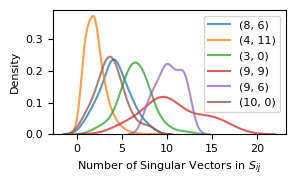

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3,1.9), sharey=True, sharex=True)
for idx, (layer, ah_idx) in enumerate(test_heads):
    sns.kdeplot([len(x) for x in sv_sets_nsi[(layer, ah_idx)]["non_src_zero_firing"]], label = f'{(layer, ah_idx)}',
                bw_method = 0.5, alpha=0.75 ,linewidth=1.5, ax=ax)
plt.xlabel(r'Number of Singular Vectors in $S_{ij}$')
plt.legend(loc = 'best')
plt.tight_layout()
plt.savefig('figures/no-of-singular-vectors-NSI.pdf', dpi=800);

### Plotting the contribution to attention score per orthogonal slice

#### IOI dataset, example 1

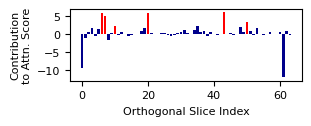

In [16]:
# Getting data for the plot
layer = 8
ah_idx = 6
prompt_id = 6
dest_token = 2
src_token = 1
perc_contrib_thresh = 1.0
X_batch = cache[f"blocks.{layer}.ln1.hook_normalized"]
X = X_batch[prompt_id, :, :] #Float[Tensor, 'n_tokens d_model']
df = get_components_used(model, X, src_token, dest_token, layer, ah_idx, U[(layer, ah_idx)], S[(layer, ah_idx)], VT[(layer, ah_idx)])
last_sv_idx = np.where(df['sv_perc_contribution'].values > perc_contrib_thresh)[0][0]
c = df.iloc[:last_sv_idx+1].idx.astype(int).values

# Plot
colors = ['red' if x in c else 'darkblue' for x in df['product'].index]
plt.figure(constrained_layout=True, figsize = (3, 1.15))
#plt.rcParams.update({'font.size': 18})
plt.bar(df['product'].index, df['product'].values, color=colors)  
#plt.xlabel("Singular Vector Index")
plt.xlabel("Orthogonal Slice Index")
#plt.ylabel("Orthogonal Layer Contribution \n to Attention Score")
plt.ylabel("Contribution\nto Attn. Score")
plt.ylim([-13, 7])
plt.yticks([-10, -5, 0, 5])
plt.savefig(f"figures/layer-contrib-ah-{layer}-{ah_idx}-{prompt_id}-{dest_token}-{src_token}-positive.pdf", dpi=800)

#### IOI dataset, example 2

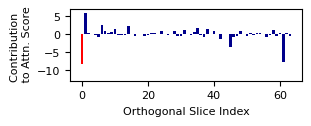

In [17]:
# Data
layer = 8
ah_idx = 6
prompt_id = 120
dest_token = 2
src_token = 1
perc_contrib_thresh = 1.0
X_batch = cache[f"blocks.{layer}.ln1.hook_normalized"]
X = X_batch[prompt_id, :, :] #Float[Tensor, 'n_tokens d_model']
df = get_components_used(model, X, src_token, dest_token, layer, ah_idx, U[(layer, ah_idx)], S[(layer, ah_idx)], VT[(layer, ah_idx)])
last_sv_idx = np.where(df['sv_perc_contribution'].values > perc_contrib_thresh)[0][0]
c = df.iloc[:last_sv_idx+1].idx.astype(int).values

# Plot
colors = ['red' if x in c else 'darkblue' for x in df['product'].index]
plt.figure(constrained_layout=True, figsize = (3, 1.15))
plt.bar(df['product'].index, df['product'].values, color=colors)  
plt.xlabel("Orthogonal Slice Index")
plt.ylabel("Contribution \n to Attn. Score")
plt.ylim([-13, 7])
plt.yticks([-10, -5, 0, 5])
plt.savefig(f"figures/layer-contrib-ah-{layer}-{ah_idx}-{prompt_id}-{dest_token}-{src_token}-negative.pdf", dpi=800) 

### Show that the SVs used by the AH tend to be similar over multiple firings

In [18]:
test_heads_heatmap = [(8, 6),(4, 11),(3, 0),(9, 9)]

#### Get the firings in the heatmap format for each AH

In [19]:
heatmap_firings = {}
for idx, (layer, ah_idx) in enumerate(tqdm(test_heads_heatmap)):
    heatmap_firings[(layer, ah_idx)] = get_heatmap_firings(ioi_dataset, model, cache, layer, ah_idx, U, S, VT, perc_contrib_thresh, thresh_firing)

100%|██████████| 4/4 [03:28<00:00, 52.08s/it]


#### Compute the heatmaps per each AH (all firing positions in which src_token is not the first one)

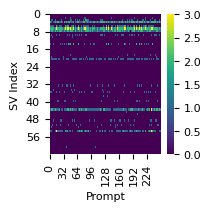

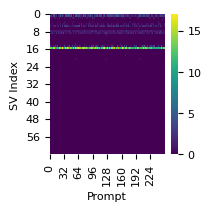

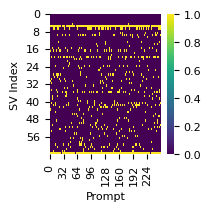

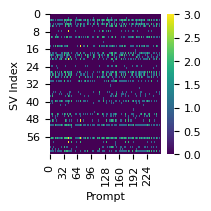

In [20]:
# Non-src zero firing
for (layer, ah_idx) in test_heads_heatmap:
    plt.figure(constrained_layout=True, figsize = (2, 2))
    sns.heatmap(heatmap_firings[(layer, ah_idx)]["non_src_zero_firing"], cmap="viridis")
    plt.xlabel("Prompt")
    plt.ylabel("SV Index")
    plt.yticks(np.arange(0, 64, 8), labels = np.arange(0, 64, 8))
    plt.xticks(np.arange(0, 256, 32), labels = np.arange(0, 256, 32))
    plt.savefig(f"figures/heatmap-non-src-zero-firing-ah-{layer}-{ah_idx}.png", dpi=800)

#### Compute the heatmaps per each AH (all non firing positions)

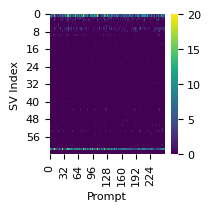

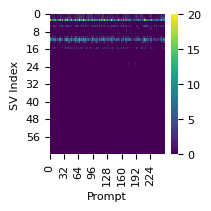

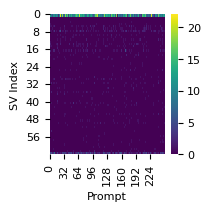

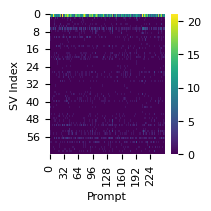

In [21]:
# Non firing
for (layer, ah_idx) in test_heads_heatmap:
    plt.figure(constrained_layout=True, figsize = (2, 2))
    sns.heatmap(heatmap_firings[(layer, ah_idx)]["non_firing"], cmap="viridis")
    plt.xlabel("Prompt")
    plt.ylabel("SV Index")
    plt.yticks(np.arange(0, 64, 8), labels = np.arange(0, 64, 8))
    plt.xticks(np.arange(0, 256, 32), labels = np.arange(0, 256, 32))
    # plt.tight_layout()
    plt.savefig(f"figures/heatmap-non-firing-ah-{layer}-{ah_idx}.png", dpi=800)

### Showing the filtering effect of orthogonal slices

In [22]:
# Build map from (prompt_id, token) to grammatical role
gram = ioi_dataset.word_idx.keys()
idx_to_gram = {}
gram_to_idx = {}
for prompt_id in range(len(ioi_dataset)):
    for g in gram:
        idx_to_gram[prompt_id, ioi_dataset.word_idx[g][prompt_id].item()] = g
        gram_to_idx[prompt_id, g] = ioi_dataset.word_idx[g][prompt_id].item()

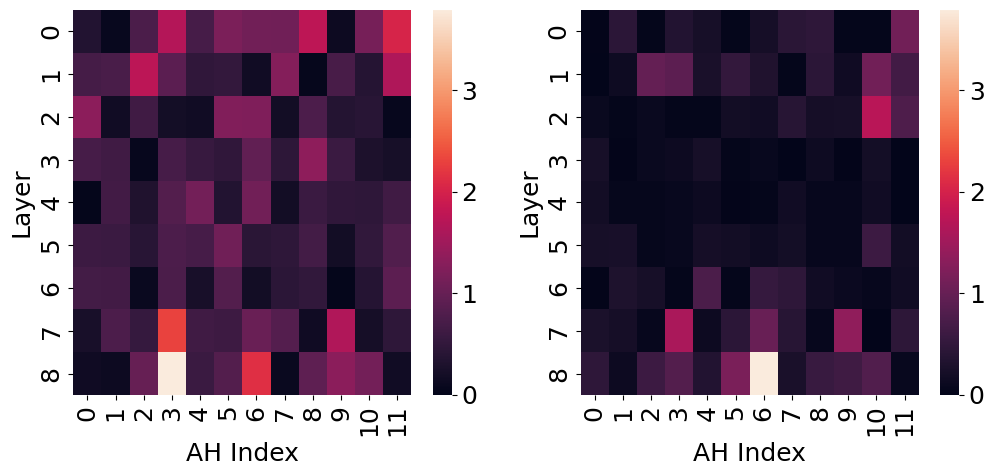

In [23]:
layer = 9
ah_idx = 9
prompt_id = 4
src_token = gram_to_idx[prompt_id, 'IO']
dest_token = gram_to_idx[prompt_id, 'end']
all_contrib = get_contrib_src_dest(model, prompt_id, layer, ah_idx, src_token, dest_token, cache, U, S, VT, perc_contrib_thresh = 'all')
sv_contrib = get_contrib_src_dest(model, prompt_id, layer, ah_idx, src_token, dest_token, cache, U, S, VT, perc_contrib_thresh = 1)
all_mat = all_contrib[1]
sv_mat = sv_contrib[1]

maxv = np.max([np.max(np.ravel(all_mat)), np.max(np.ravel(sv_mat))])
minv = np.min([np.min(np.ravel(all_mat)), np.min(np.ravel(sv_mat))])
plt.rcParams.update({'font.size': 18})

figs, axs = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(np.abs(all_mat), ax = axs[0], vmin = 0, vmax = maxv)
axs[0].set_ylabel('Layer')
axs[0].set_xlabel('AH Index')
sns.heatmap(np.abs(sv_mat), ax = axs[1], vmin = 0, vmax = maxv)
axs[1].set_ylabel('Layer')
axs[1].set_xlabel('AH Index')
plt.savefig(f'figures/paper_additional-{layer}-{ah_idx}-{prompt_id}-selected-svs.png', bbox_inches="tight")

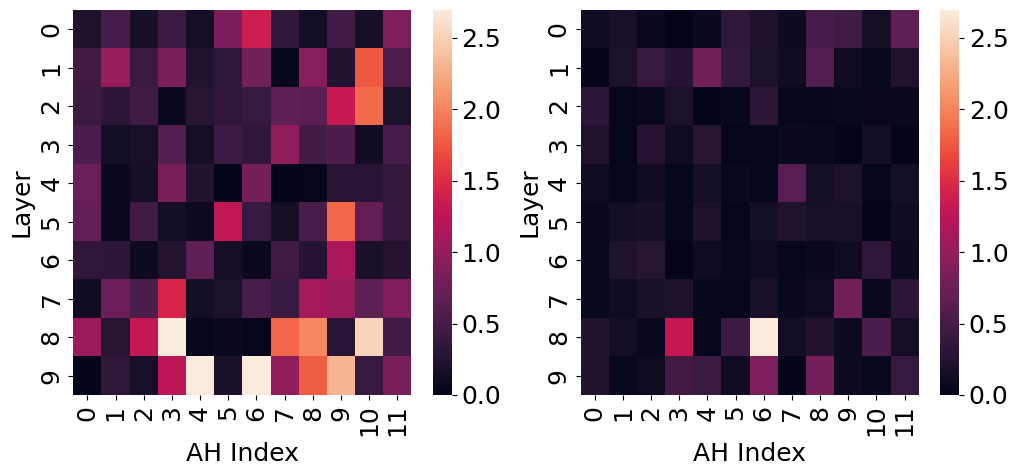

In [24]:
layer = 10
ah_idx = 0
prompt_id = 51
src_token = gram_to_idx[prompt_id, 'IO']
dest_token = gram_to_idx[prompt_id, 'end']
all_contrib = get_contrib_src_dest(model, prompt_id, layer, ah_idx, src_token, dest_token, cache, U, S, VT, perc_contrib_thresh = 'all')
sv_contrib = get_contrib_src_dest(model, prompt_id, layer, ah_idx, src_token, dest_token, cache, U, S, VT, perc_contrib_thresh = 1)
all_mat = all_contrib[1]
sv_mat = sv_contrib[1]

maxv = np.max([np.max(np.ravel(all_mat)), np.max(np.ravel(sv_mat))])
minv = np.min([np.min(np.ravel(all_mat)), np.min(np.ravel(sv_mat))])
plt.rcParams.update({'font.size': 18})
figs, axs = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(np.abs(all_mat), ax = axs[0], vmin = 0, vmax = maxv)
axs[0].set_ylabel('Layer')
axs[0].set_xlabel('AH Index')
sns.heatmap(np.abs(sv_mat), ax = axs[1], vmin = 0, vmax = maxv)
axs[1].set_ylabel('Layer')
axs[1].set_xlabel('AH Index')
plt.savefig(f'figures/paper_additional-{layer}-{ah_idx}-{prompt_id}-selected-svs.png', bbox_inches="tight")

In [25]:
plt.rcParams.update({'font.size': 6})

### Average Magnitude of the (9, 9) $\mathcal{V}$ Space Signal in Each Token

In [26]:
# Get IOI dataset vocab.
ioi_vocab = set(ioi_dataset.toks.reshape(-1).tolist())
# Remove end of sequence token.
ioi_vocab.remove(50256)
ioi_vocab = list(ioi_vocab)
len(ioi_vocab)

152

In [27]:
idx_token_map = {i: model.tokenizer.decode([ioi_vocab[i]]) for i in range(len(ioi_vocab))}

In [28]:
input_layer = 9 # where we are going to get the residuals (input after LN1)
layer, ah_idx = 9, 9 # where we are going to get the SVs from
dest_token_list = ioi_dataset.word_idx["end"]
src_token_list = ioi_dataset.word_idx["IO"]

In [29]:
SSVS = []
count = 0
for prompt_idx in range(len(ioi_dataset)):
    dest_token = dest_token_list[prompt_idx].item()
    src_token = src_token_list[prompt_idx].item()
    try:
        SSVS.append(svs_used[(prompt_idx, layer, ah_idx, dest_token, src_token)])
    except KeyError:
        continue
len(SSVS)

201

In [30]:
# Make SSVS flat
SSVS_flat = []
for ssvs in SSVS:
    for ssv in ssvs:
        SSVS_flat.append(ssv)
len(SSVS_flat)

2504

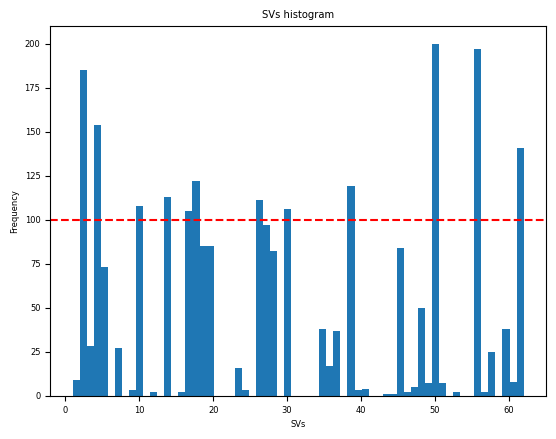

In [31]:
# Plotting the SVs histogram
plt.hist(SSVS_flat, bins=64);
# Line at y=100
plt.axhline(100, color='r', linestyle='--');
plt.xlabel("SVs");
plt.ylabel("Frequency");
plt.title("SVs histogram");

In [32]:
# Getting SVs that appeared more that 100 times
threshold = 100
SVs_top = [sv for sv in set(SSVS_flat) if SSVS_flat.count(sv) >= threshold]
SVs_top

[2, 4, 10, 14, 17, 18, 26, 30, 39, 50, 56, 62]

In [33]:
len(SVs_top)

12

In [34]:
# Computing the norm of the projections for each token and saving them in a dictionary
projection_norms_V = {token: [] for token in list(idx_token_map.values())}

P_u, P_v, P_u_perp, P_v_perp = compute_projections(U[(layer, ah_idx)], VT[(layer, ah_idx)], SVs_top)

for prompt_idx in tqdm(range(len(ioi_dataset))):
    end_token_idx = ioi_dataset.word_idx["end"][prompt_idx]

    # (V-projection)
    # Intervention
    x_in_interv = deepcopy(cache[f"blocks.{input_layer}.ln1.hook_normalized"][prompt_idx, :end_token_idx+1, :]) # [n_tokens, d_model]
    for pos in range(x_in_interv.shape[0]):
        x_in_interv[pos] = projection_intervention(x_in_interv, P_v, pos, intervention_type="V")[pos]

    norm_x_in_interv = torch.norm(x_in_interv, dim=-1)

    for token_idx, token in enumerate(ioi_dataset.toks[prompt_idx, :end_token_idx+1]):
        token = model.tokenizer.decode([token.item()])
        projection_norms_V[token].append(norm_x_in_interv[token_idx].cpu().numpy())

100%|██████████| 256/256 [00:04<00:00, 58.13it/s]


In [35]:
# Getting averages for each token
projection_norms_V_avg = {token: np.mean(projection_norms_V[token]) for token in projection_norms_V}
# Getting token rank by average projection norm (from lowest norm to highest norm)
token_rank_V = sorted(projection_norms_V_avg, key=projection_norms_V_avg.get)[::-1]
# Getting the norms sorted by token rank
projection_norms_V_avg_by_token_rank = [projection_norms_V_avg[token] for token in token_rank_V]
# Getting the cumulative sum of the names (V-projection)
# For each token (sorted by its rank), we assign 1 if it is a name, -1 otherwise
cum_sum_names_V = []
for token in token_rank_V:
    if token in NAMES:
        cum_sum_names_V.append(1)
    else:
        cum_sum_names_V.append(-1)
cum_sum_names_V = np.cumsum(cum_sum_names_V)

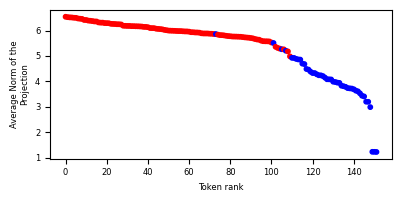

In [36]:
plt.figure(figsize = (4,2))
color = ['r' if token in NAMES else 'b' for token in token_rank_V]
plt.scatter(range(len(projection_norms_V_avg_by_token_rank)), projection_norms_V_avg_by_token_rank, s = 10, c = color)
plt.xlabel("Token rank");
plt.ylabel("Average Norm of the\nProjection")
plt.tight_layout()
plt.savefig("figures/V-projection.pdf", bbox_inches='tight')

### Single-edge Interventions 

In [38]:
interventions_single_edge = pd.read_parquet("data/interventions_single-edge.parquet")
interventions_single_edge.head()

,prompt_id,downstream_node,edge,logit_diff,logit_diff_interv,norm_ratio,cosine_similarity,intervention_type,intervention_type_name,is_boosting,is_random,edge_weight,scores_dest_src_downstream_ah,scores_dest_src_downstream_ah_interv,is_ablated,scores_dest_src_diff_metric,logit_diff_metric
0,0,"(9, 6, 'end')","('(0, 1)', ""(9, 6, 'end')"")",1.348155,1.348155,1.000000,1.000000,A,A (SVs),False,False,0.543746,3.524789,3.524789,False,0.000000,0.000000
1,1,"(9, 6, 'end')","('(0, 1)', ""(9, 6, 'end')"")",4.028567,4.048396,0.995451,0.999578,A,A (SVs),False,False,0.543746,5.386482,5.401872,True,0.015390,0.019829
2,2,"(9, 6, 'end')","('(0, 1)', ""(9, 6, 'end')"")",4.013285,4.003185,0.996986,0.999487,A,A (SVs),False,False,0.543746,5.884322,5.874791,True,-0.009531,-0.010099
3,3,"(9, 6, 'end')","('(0, 1)', ""(9, 6, 'end')"")",3.566335,3.538719,0.996794,0.999258,A,A (SVs),False,False,0.543746,6.400779,6.380621,True,-0.020158,-0.027616
4,4,"(9, 6, 'end')","('(0, 1)', ""(9, 6, 'end')"")",4.977374,4.970709,0.997802,0.999700,A,A (SVs),False,False,0.543746,4.744489,4.743128,True,-0.001360,-0.006665


In [39]:
def edge_format(s):
    return s.replace("\'", "").replace('"','').replace('((','(').replace('))',')').replace('), (',') ->\n (')

interventions_single_edge['edge_display'] = interventions_single_edge['edge'].apply(lambda x: edge_format(x))

#### Interventions plots

In [40]:
top_edges = {}
edges_ranking = {}

top_filter = 4

for node in interventions_single_edge.downstream_node.unique():
    if node == '(0, 9)':
        edges = np.array(list(G.out_edges(node)))
    else:
        edges = np.array(list(G.in_edges(node)))

    edges_weights = []
    for edge in edges:
        edge_weight = G.edges[edge]['weight']
        edges_weights.append(edge_weight)
    
    sorted_edges_idx = np.argsort(edges_weights)[::-1]
    edges_ranking[node] = {str(tuple(edges[sorted_edges_idx[i]])): i  for i in range(len(edges))}
    
    # Getting the top edges using top_filter
    if node == '(0, 9)':
        top_edge = edges[sorted_edges_idx][0]
        top_edges[node] = edges[sorted_edges_idx][:top_filter]
    else:
        top_edges[node] = edges[sorted_edges_idx][:top_filter]

Downstream node: (0, 9), Intervention type: A
Downstream node: (0, 9), Intervention type: B
Downstream node: (10, 0, 'IO'), Intervention type: A
Downstream node: (10, 0, 'IO'), Intervention type: B
Downstream node: (10, 0, 'end'), Intervention type: A
Downstream node: (10, 0, 'end'), Intervention type: B
Downstream node: (8, 6, 'S2'), Intervention type: A
Downstream node: (8, 6, 'S2'), Intervention type: B
Downstream node: (8, 6, 'end'), Intervention type: A
Downstream node: (8, 6, 'end'), Intervention type: B
Downstream node: (9, 6, 'IO'), Intervention type: A
Downstream node: (9, 6, 'IO'), Intervention type: B
Downstream node: (9, 6, 'end'), Intervention type: A
Downstream node: (9, 6, 'end'), Intervention type: B
Downstream node: (9, 9, 'IO'), Intervention type: A
Downstream node: (9, 9, 'IO'), Intervention type: B
Downstream node: (9, 9, 'end'), Intervention type: A
Downstream node: (9, 9, 'end'), Intervention type: B


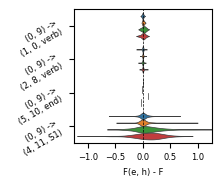

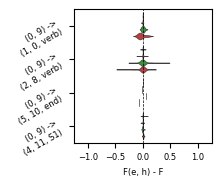

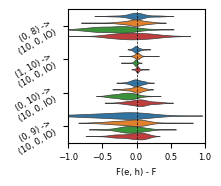

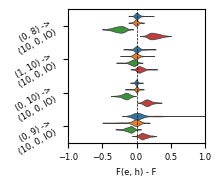

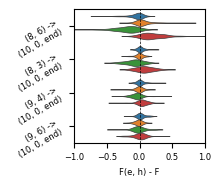

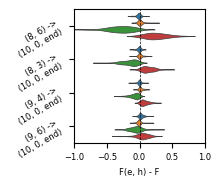

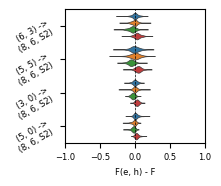

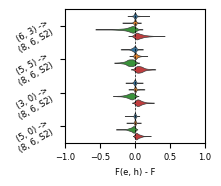

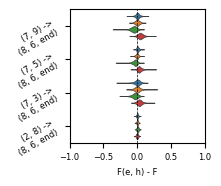

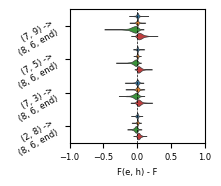

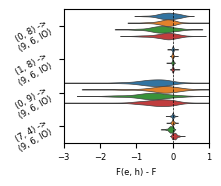

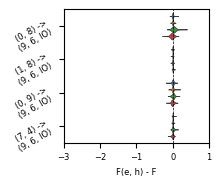

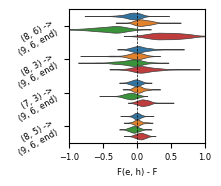

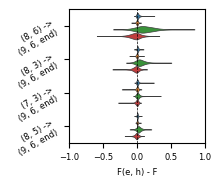

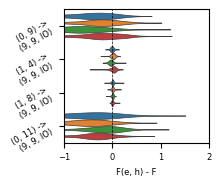

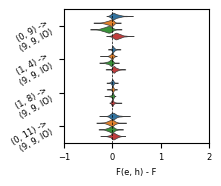

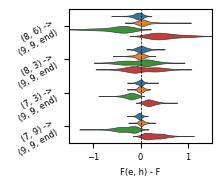

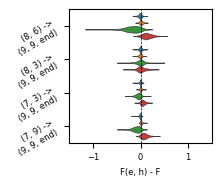

In [41]:
xscale = {
    "(9, 6, 'end')": [-1, 1],
    "(9, 9, 'end')": [-1.5, 1.5],
    "(10, 0, 'end')": [-1, 1],
    "(9, 6, 'IO')": [-3, 1],
    "(9, 9, 'IO')": [-1, 2],
    "(10, 0, 'IO')": [-1, 1],
    '(0, 9)': [-1.25, 1.25],
    "(8, 6, 'S2')" : [-1, 1],
    "(8, 6, 'end')": [-1, 1],
}

for downstream_node in sorted(interventions_single_edge.downstream_node.unique()):
    for intervention_type in interventions_single_edge.intervention_type.unique():
        plt.figure(constrained_layout=True, figsize = (2.1, 1.75))
        print(f"Downstream node: {downstream_node}, Intervention type: {intervention_type}")
        df = deepcopy(interventions_single_edge[(interventions_single_edge["downstream_node"] == downstream_node) & (interventions_single_edge["intervention_type"] == intervention_type)])
        df["type_ablation"] = df.apply(lambda x: x.intervention_type_name + " - " + ("Boosting" if x.is_boosting else "Ablating"), axis=1)
        # Computing edge ranking
        df["edge_ranking"] = df["edge"].replace(edges_ranking[downstream_node])
        # Filter only is_ablated=True
        df = df[df.is_ablated]
        df = df[df["edge_ranking"] < top_filter].sort_values('edge_ranking')
        # sns.scatterplot(data=df, x="logit_diff_metric", y="edge_ranking", hue="type_ablation", s=10, hue_order=sorted(df["type_ablation"].unique()))
        sns.violinplot(data=df, x="logit_diff_metric", y="edge_display", orient = "h", 
                       density_norm = 'width', inner = None, 
                       hue="type_ablation", hue_order=sorted(df["type_ablation"].unique()),
                       linewidth=0.5)
        # Draw the line at x=0
        plt.axvline(x=0, color="black", linestyle="--", linewidth=0.5)
        plt.legend().remove()
        plt.ylabel(None)
        plt.xlabel('F(e, h) - F')
        plt.xlim(xscale[downstream_node])
        plt.yticks(rotation=30)
        figname=f'figures/violin-{downstream_node}-{intervention_type}.pdf'
        plt.savefig(figname, dpi=800)

#### Cosine similarity

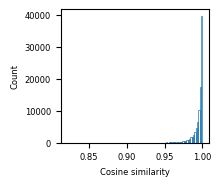

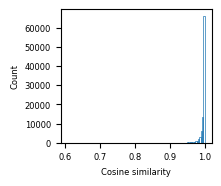

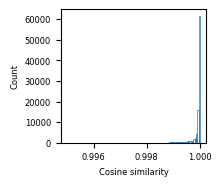

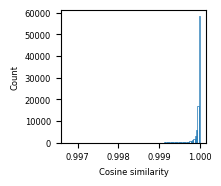

In [42]:
for i, intervention_type_name in enumerate(interventions_single_edge.intervention_type_name.unique()):
    plt.figure(constrained_layout=True, figsize = (2.1, 1.75))
    sns.histplot(interventions_single_edge[(interventions_single_edge.intervention_type_name == intervention_type_name) & (interventions_single_edge.is_ablated)], x="cosine_similarity", bins=100, fill=False, stat="count");
    plt.xlabel("Cosine similarity")
    plt.ylabel("Count")
    plt.savefig(f"figures/cosine_similarity_single_edge_intervention_{intervention_type_name}.pdf", dpi=800)

#### Norm ratio

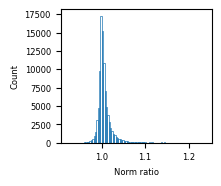

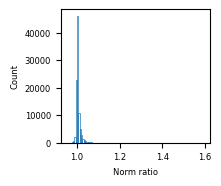

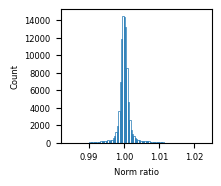

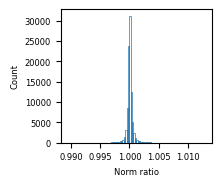

In [43]:
for i, intervention_type_name in enumerate(interventions_single_edge.intervention_type_name.unique()):
    plt.figure(constrained_layout=True, figsize = (2.1, 1.75))
    sns.histplot(interventions_single_edge[(interventions_single_edge.intervention_type_name == intervention_type_name) & (interventions_single_edge.is_ablated)], x="norm_ratio", bins=100, fill=False, stat="count");
    plt.xlabel("Norm ratio")
    plt.ylabel("Count")
    plt.savefig(f"figures/norm_ratio_single_edge_intervention_{intervention_type_name}.pdf", dpi=800)

#### Attention scores effect

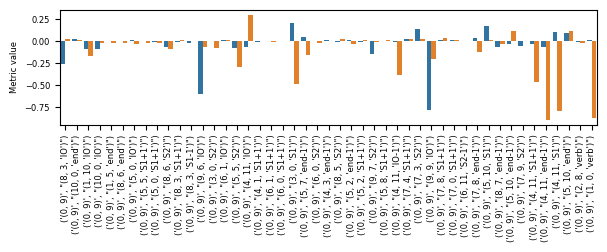

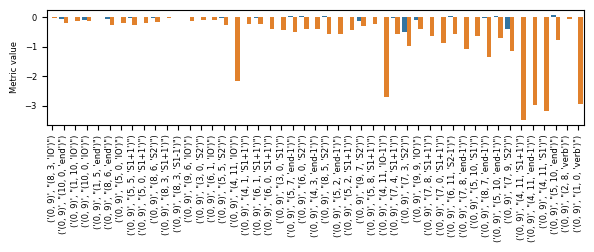

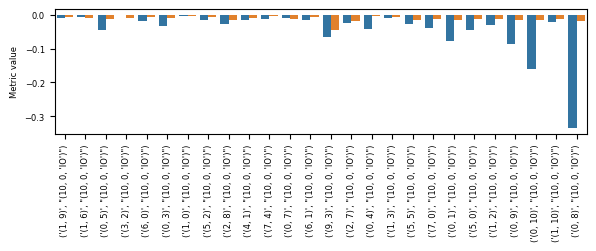

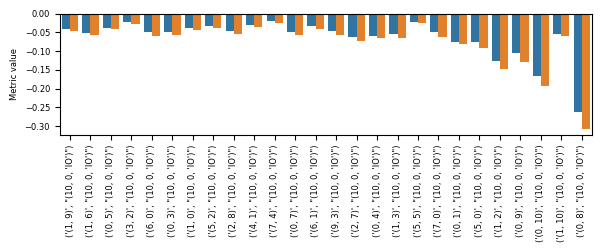

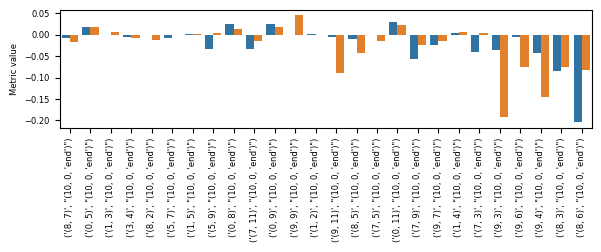

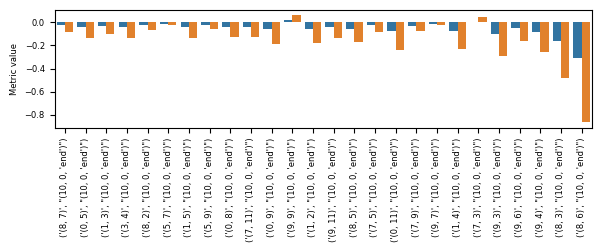

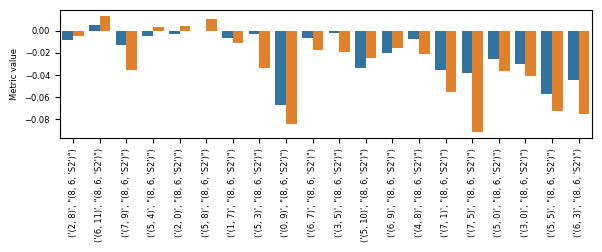

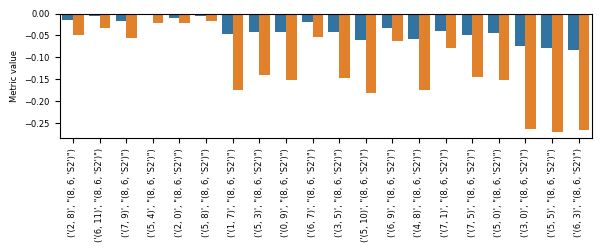

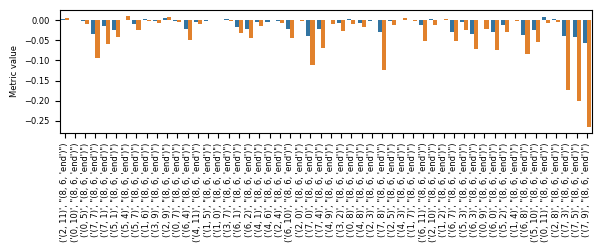

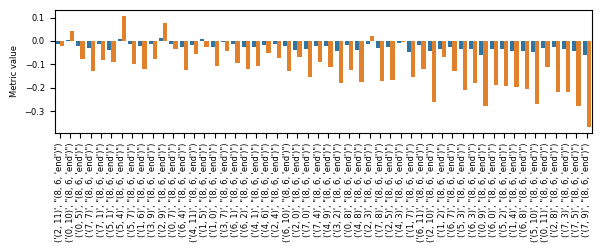

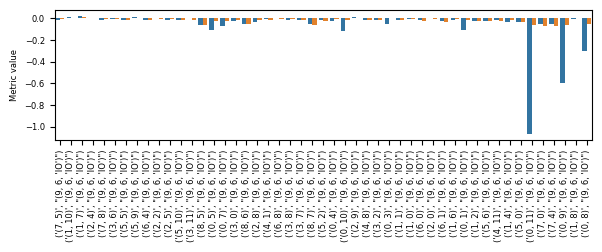

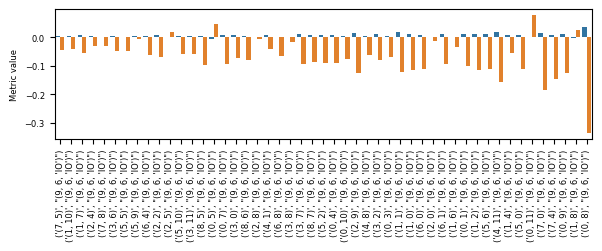

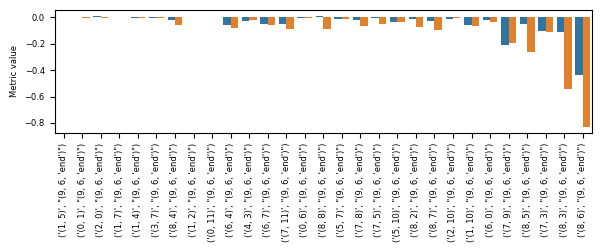

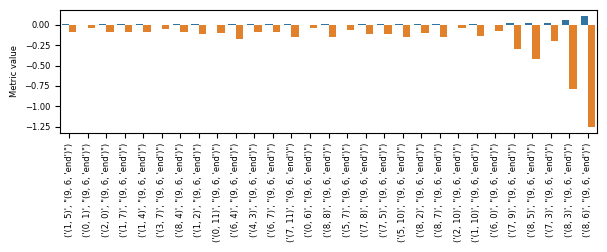

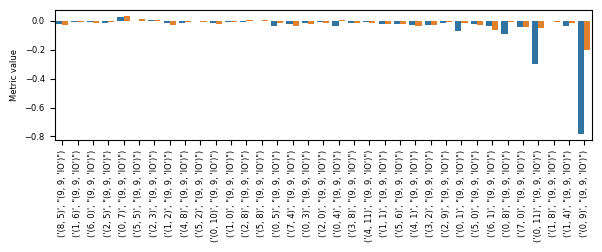

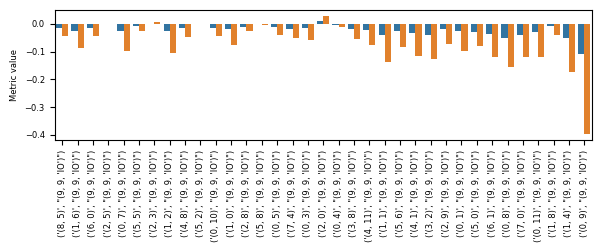

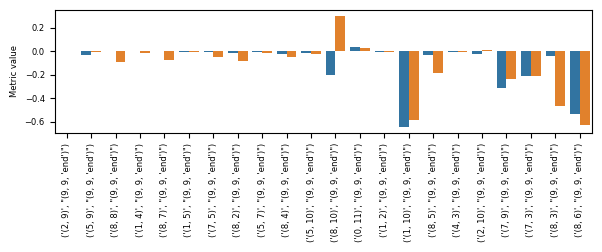

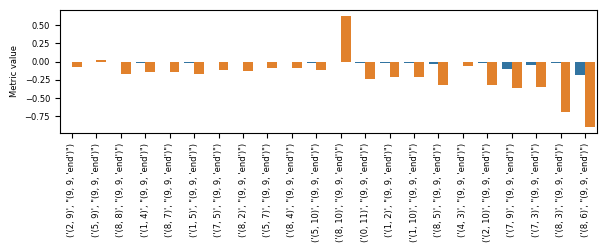

In [44]:
for downstream_node in sorted(interventions_single_edge.downstream_node.unique()):
    df_dn = deepcopy(interventions_single_edge[interventions_single_edge.downstream_node == downstream_node])
    for idx, intervention_type_name in enumerate(["A (SVs)", "B (SVs)"]):
        df = deepcopy(df_dn[(df_dn.intervention_type_name == intervention_type_name) & (df_dn.is_boosting == False)])
        df = df[df.is_ablated]
        df = df.sort_values("edge_weight", ascending=True)
        
        df_melted = df.melt(var_name='metric', value_name='value', id_vars='edge', value_vars=['logit_diff_metric', "scores_dest_src_diff_metric"])
        fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
        ax = sns.barplot(data=df_melted, x='edge', y='value', hue='metric', errorbar=None, ax=ax, legend=False)
        # Set ax legend labels
        node_type = "upstream" if downstream_node == "(0, 9)" else "downstream"
        plt.xticks(rotation=90);
        plt.xlabel(None);
        plt.ylabel("Metric value");
        plt.tight_layout()
        plt.savefig(f"figures/intervention_attn_scores_{downstream_node}_{node_type}_{intervention_type_name}.pdf", dpi=800)

### Multi-edge interventions

In [45]:
interventions_multi_edge = pd.read_parquet("data/interventions_multi-edge.parquet")
interventions_multi_edge.head()

,prompt_id,edges,logit_diff,logit_diff_interv,intervention_type,intervention_type_name,is_boosting,is_random,logit_diff_metric,is_ablated,cosine_similarities,norm_ratio,experiment
0,0,"[('(8, 6)', ""(9, 9, 'end')"")]",1.348155,1.348155,A,A (SVs),False,False,0.000000,False,1.000000,1.000000,A
1,1,"[('(8, 6)', ""(9, 9, 'end')"")]",4.028567,3.695608,A,A (SVs),False,False,-0.332959,True,0.989835,0.967867,A
2,2,"[('(8, 6)', ""(9, 9, 'end')"")]",4.013285,3.557313,A,A (SVs),False,False,-0.455972,True,0.986161,0.966421,A
3,3,"[('(8, 6)', ""(9, 9, 'end')"")]",3.566335,3.176723,A,A (SVs),False,False,-0.389611,True,0.989332,0.973014,A
4,4,"[('(8, 6)', ""(9, 9, 'end')"")]",4.977374,4.461103,A,A (SVs),False,False,-0.516271,True,0.987033,0.976302,A


In [46]:
def edge_format_multiedge(s):
    if "All" in s:
        if "incoming" in s:
            s = s.replace("All incoming edges to", "All") + "\nincoming edges"
        else:
            s = s.replace("All outgoing edges from", "All") + "\noutgoing edges"
        s = s.replace("+", "+\n")
        return s
        
    list_s = eval(s)
    new_list_s = []

    if len(list_s) == 1:
        return str(list_s[0]).replace("\'", "").replace('"','').replace('((','(').replace('))',')').replace('), (',') ->\n (')
    else:
        for i in range(len(list_s)):
            new_list_s.append(str(list_s[i]).replace("\'", "").replace('"','').replace('((','(').replace('))',')').replace('), (',') ->\n ('))
        joined = ",\n".join(new_list_s)
        return f"[{joined}]"

In [47]:
interventions_multi_edge['edges'] = interventions_multi_edge['edges'].apply(lambda x: edge_format_multiedge(x))

#### Invervention plots

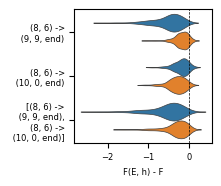

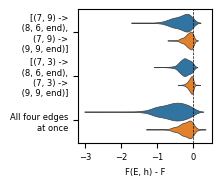

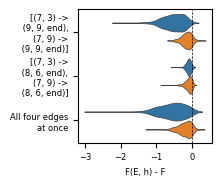

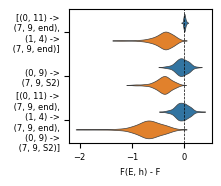

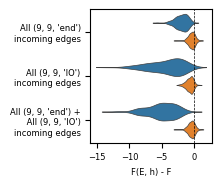

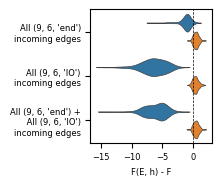

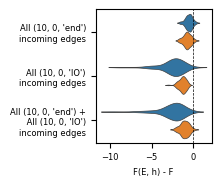

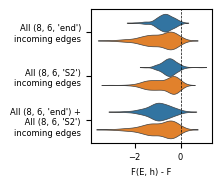

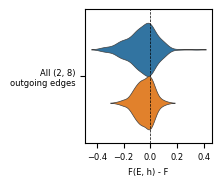

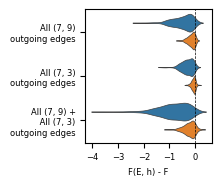

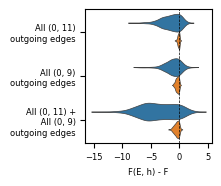

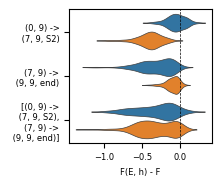

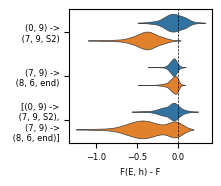

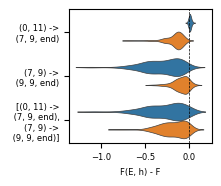

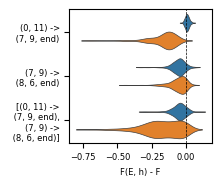

In [48]:
for experiment in sorted(interventions_multi_edge.experiment.unique()):
    df = deepcopy(interventions_multi_edge[interventions_multi_edge.experiment == experiment])
    df = deepcopy(df[df.is_ablated])
    df["intervention_type_name"] = df.intervention_type.apply(lambda x: "Global" if x == "A" else "Local")
    if experiment == "B":
        df.edges.replace('[(7, 9) ->\n (8, 6, end),\n(7, 9) ->\n (9, 9, end),\n(7, 3) ->\n (8, 6, end),\n(7, 3) ->\n (9, 9, end)]', "All four edges\nat once", inplace=True)
    if experiment == "C":
        df.edges.replace('[(7, 3) ->\n (9, 9, end),\n(7, 9) ->\n (9, 9, end),\n(7, 3) ->\n (8, 6, end),\n(7, 9) ->\n (8, 6, end)]', "All four edges\nat once", inplace=True)
    plt.figure(constrained_layout=True, figsize = (2.1, 1.75))
    sns.violinplot(data=df, x="logit_diff_metric", y="edges", hue="intervention_type_name", 
                   hue_order=["Global", "Local"], 
                   linewidth=0.5, legend=False,
                   density_norm = 'width', inner = None)
    # Set legend title
    # Draw a line at x=0
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    plt.xlabel("F(E, h) - F");
    plt.ylabel(None)
    plt.savefig(f"figures/intervention_multiedge_{experiment}.pdf", dpi=800);

#### Cosine similarity

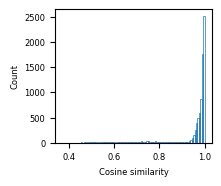

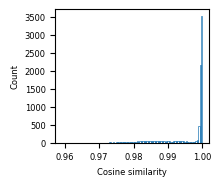

In [49]:
for i, intervention_type_name in enumerate(interventions_multi_edge.intervention_type_name.unique()):
    plt.figure(constrained_layout=True, figsize = (2.1, 1.75))
    sns.histplot(interventions_multi_edge[(interventions_multi_edge.intervention_type_name == intervention_type_name) & (interventions_multi_edge.is_ablated)], x="cosine_similarities", bins=100, fill=False, stat="count");
    plt.xlabel("Cosine similarity")
    plt.ylabel("Count")
    plt.savefig(f"figures/cosine_similarity_multi_edge_intervention_{intervention_type_name}.pdf", dpi=800)

#### Norm ratio

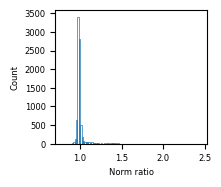

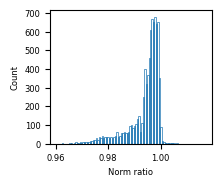

In [50]:
for i, intervention_type_name in enumerate(interventions_multi_edge.intervention_type_name.unique()):
    plt.figure(constrained_layout=True, figsize = (2.1, 1.75))
    sns.histplot(interventions_multi_edge[(interventions_multi_edge.intervention_type_name == intervention_type_name) & (interventions_multi_edge.is_ablated)], x="norm_ratio", bins=100, fill=False, stat="count");
    plt.xlabel("Norm ratio")
    plt.ylabel("Count")
    plt.savefig(f"figures/norm_ratio_multi_edge_intervention_{intervention_type_name}.pdf", dpi=800)